In [0]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Dense, GlobalAveragePooling2D
from keras import optimizers
from keras.layers import Dropout, Flatten
from keras.models import load_model
from PIL import Image
import cv2
from __future__ import print_function #not sure if this is needed
!pip install -U -q PyDrive

In [105]:
#This cell mounts your google drive to allow for fiel access and storage
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#here is an example of opening a file from your mounted google drive

img = cv2.imread('drive/My Drive/EPICProjectThree/dylanOriginal384x384.png')
# print (type(img))
# print (img.shape)

In [0]:
originalDimX=img.shape[0]
# print(originalDimX)
originalDimY=img.shape[1]
# print(originalDimY)

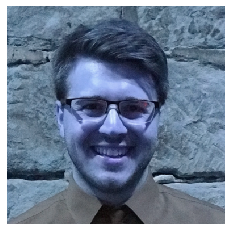

In [109]:
#taking a look at the image we read
plt.imshow(img)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

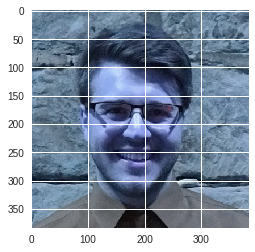

In [110]:
#To run the model on this image we need to crop to just the face
face_cascade = cv2.CascadeClassifier('drive/My Drive/EPICProjectThree/haarcascade_frontalface_default.xml')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# imgray = (255-gray)
plt.imshow(img, cmap = 'gray')

84 99 205 205


(-0.5, 383.5, 383.5, -0.5)

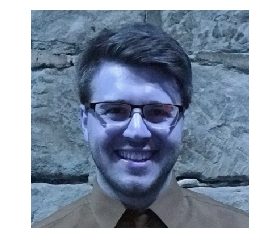

In [115]:
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    print(x,y,w,h)
plt.imshow(img)
plt.axis('off')

(-0.5, 204.5, 204.5, -0.5)

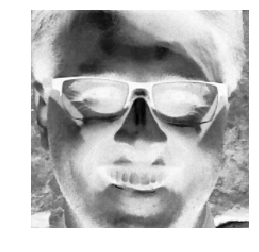

In [116]:
# cropping the image down to just the face that face_cascade detected
imgCropped = gray[y:y+h, x:x+w]
plt.imshow(imgCropped)
plt.axis('off')

In [117]:
#saving the dimensions of the cropped image and the crop distances
croppedDimX=imgCropped.shape[0]
print(croppedDimX)
croppedDimY=imgCropped.shape[1]
print(croppedDimX)
cropOffsetX = (originalDimX - croppedDimX)/2
print(cropOffsetX)
cropOffsetY = (originalDimY - croppedDimY)/2
print(cropOffsetY)

205
205
89.5
89.5


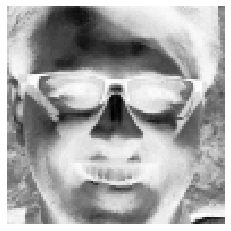

(96, 96)
0.4682926829268293
0.4682926829268293


In [118]:
#resizing image to 96x96 for model prediction
imgCropped96 = cv2.resize(imgCropped, (96, 96))
plt.imshow(imgCropped96)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
print(imgCropped96.shape)

#calculating the resizing ratios
ratioTo96x = 96/croppedDimX
ratioTo96y = 96/croppedDimY
print(ratioTo96x)
print(ratioTo96y)

In [119]:
#converting pixel data to 0-1 format for model
imgCropped96 = imgCropped96 / 255
imgCropped96.shape

(96, 96)

In [120]:
#To use the model we need to setup a pipeline for the output array
df = pd.read_csv('drive/My Drive/EPICProjectThree/training.csv')
twoKGoodFaces = df.dropna()
y = np.vstack(twoKGoodFaces[twoKGoodFaces.columns[:-1]].values)
y.shape, y.dtype

((2140, 30), dtype('float64'))

In [0]:
#loading the model that was trained to predict keypoints
model = load_model('drive/My Drive/EPICProjectThree/tKeypointModel1227.h5')

In [0]:
# Creating pipeline
output_pipe = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1))
)
y_train = output_pipe.fit_transform(y)

In [123]:
#making predictions for our target face
predictions = model.predict(imgCropped96[np.newaxis, :, :, np.newaxis])
predictions

predictions

array([[ 0.21318138,  0.41860318, -0.03817227,  0.22884798,  0.28315654,
         0.27354407,  0.15982074,  0.2616652 ,  0.12717368,  0.32766417,
        -0.18249983,  0.00736119,  0.26592076,  0.33467358,  0.25503427,
         0.27016357,  0.32516187,  0.31166318, -0.29173118,  0.21407804,
         0.13468927, -0.00131476, -0.10772062, -0.02043191, -0.06696464,
        -0.08383137, -0.0610001 , -0.14961508, -0.17302379,  0.15657398]],
      dtype=float32)

In [124]:
#converting the predictions to x,y coordinates
xy_predictions = output_pipe.inverse_transform(predictions).reshape(15, 2)
xy_predictions

array([[66.14104 , 39.650013],
       [30.258982, 37.803722],
       [59.258316, 39.92568 ],
       [72.713455, 41.013905],
       [37.1772  , 38.622044],
       [22.906862, 38.348293],
       [55.944237, 32.1651  ],
       [79.84741 , 34.846657],
       [42.446613, 31.540358],
       [16.521904, 32.427227],
       [47.62426 , 58.752926],
       [62.115543, 75.463806],
       [28.996431, 73.52617 ],
       [46.13131 , 72.53505 ],
       [45.200222, 79.54069 ]], dtype=float32)

(-0.5, 95.5, 95.5, -0.5)

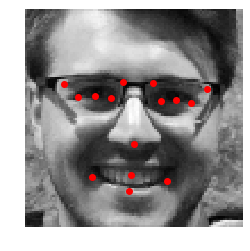

In [125]:
#taking a look at our predicted keypoints on our target face
plt.imshow(imgCropped96, cmap='gray')
plt.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'ro')
plt.axis('off')

In [126]:
#increasing the scale of the predicted keypoitn to the size of the original image after cropping
scaledUpPredictions = xy_predictions/ratioTo96x
print(scaledUpPredictions)

[[141.23868   84.6693  ]
 [ 64.61553   80.7267  ]
 [126.5412    85.25796 ]
 [155.27353   87.58177 ]
 [ 79.38882   82.47416 ]
 [ 48.915695  81.88959 ]
 [119.46426   68.68589 ]
 [170.50749   74.41213 ]
 [ 90.641205  67.35181 ]
 [ 35.28115   69.24564 ]
 [101.69764  125.461975]
 [132.64256  161.14667 ]
 [ 61.919464 157.009   ]
 [ 98.50957  154.89255 ]
 [ 96.52131  169.85251 ]]


In [127]:
#Adding offsets to scaled image to adjust for cropping
predictionsForOriginal = scaledUpPredictions + cropOffsetX
print(predictionsForOriginal)


[[230.73868 174.1693 ]
 [154.11554 170.2267 ]
 [216.0412  174.75797]
 [244.77353 177.08177]
 [168.88882 171.97415]
 [138.4157  171.38959]
 [208.96426 158.18588]
 [260.0075  163.91214]
 [180.1412  156.8518 ]
 [124.78115 158.74564]
 [191.19763 214.96198]
 [222.14256 250.64667]
 [151.41946 246.509  ]
 [188.00957 244.39255]
 [186.0213  259.3525 ]]


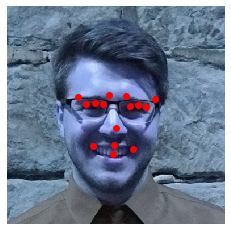

In [128]:
#putting the predicted keypoints on the original image
plt.imshow(img, cmap = 'gray')
plt.plot(predictionsForOriginal[:, 0], predictionsForOriginal[:, 1], 'ro')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [0]:
#now preparing to add an accessory item to the face

In [0]:
# These files are a 'workaround', 'trick', or 'hack' to get around the fact that when Pillow scales 
# a png image, it loses transparency. Invoking these functions on the image before and after a 'resize' 
# will retain transparency. See next cell for example use.

def premultiply(im):
    pixels = im.load()
    for y in range(im.size[1]):
        for x in range(im.size[0]):
            r, g, b, a = pixels[x, y]
            if a != 255:
                r = r * a // 255
                g = g * a // 255
                b = b * a // 255
                pixels[x, y] = (r, g, b, a)

def unmultiply(im):
    pixels = im.load()
    for y in range(im.size[1]):
        for x in range(im.size[0]):
            r, g, b, a = pixels[x, y]
            if a != 255 and a != 0:
                r = 255 if r >= a else 255 * r // a
                g = 255 if g >= a else 255 * g // a
                b = 255 if b >= a else 255 * b // a
                pixels[x, y] = (r, g, b, a)

In [131]:
# For now I am assuming a single CSV file expected to have an accessory image file name in the first column and coordinates in other columns.

imageFile = 'drive/My Drive/EPICProjectThree/accessoryKeypoints.csv'
imagesDF = pd.read_csv(imageFile)
imagesDF

,file_name,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,redSunGlasses457x172.png,322.4403,71.0892,139.6395,71.0892,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,oakleys.png,400.0000,155.0000,190.0000,155.0000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


PNG (600, 330) RGBA


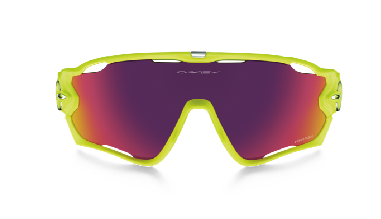

In [132]:
imageDirectoryPath = 'drive/My Drive/EPICProjectThree/'
accessoryFileName = 'oakleys.png'
accessoryFilePath = imageDirectoryPath + accessoryFileName
accessory = Image.open(accessoryFilePath)
print(accessory.format, accessory.size, accessory.mode)
plt.imshow(accessory)
plt.axis('off')
plt.show()

In [0]:
# Picking the row out of the datatable with the accessory info
accessoryRowDF = imagesDF.loc[imagesDF['file_name'] == accessoryFileName]


In [0]:
# Comparing the target face eye width (center to center) 
# and the accessory eye width (center to center) to determine the scaling factor to make the accessory fit the face
imageEyeWidth = predictionsForOriginal[0, 0]-predictionsForOriginal[1, 0]
# print("face eye width: ",imageEyeWidth)
accessoryEyeWidth = accessoryRowDF.iloc[0]["left_eye_center_x"]-accessoryRowDF.iloc[0]["right_eye_center_x"]
# print("accessory eye width: ", accessoryEyeWidth)
scaleFactorAcsy2Face = accessoryEyeWidth/imageEyeWidth
# print("Scale factor: " , scaleFactorAcsy2Face)

In [0]:
# Calculating the new accessory size and keypoint coordinates
newAcsySize = accessory.size/scaleFactorAcsy2Face
newAcsySize = newAcsySize.astype(int)
newAcsyLeftEyeCenterX = int(accessoryRowDF.iloc[0]["left_eye_center_x"]/scaleFactorAcsy2Face)
newAcsyRightEyeCenterX = int(accessoryRowDF.iloc[0]["right_eye_center_x"]/scaleFactorAcsy2Face)
newAcsyLeftEyeCenterY = int(accessoryRowDF.iloc[0]["left_eye_center_y"]/scaleFactorAcsy2Face)
newAcsyRightEyeCenterY = int(accessoryRowDF.iloc[0]["right_eye_center_y"]/scaleFactorAcsy2Face)
# print("new accessory dimensions: ",newAcsySize)

In [0]:
#Scaling the accessory image file with pre and post processing functions to maintain transparency
premultiply(accessory)
accessory = accessory.resize(newAcsySize)
unmultiply(accessory)
# print(accessory.format, accessory.size, accessory.mode)
accessory.show()

<function matplotlib.pyplot.show>

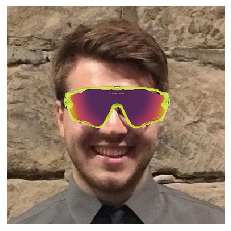

In [138]:
# pasting the resized, transparent png accessory image onto the test image

targetFaceFileName = 'dylanOriginal384x384.png'
targetFaceFilePath = imageDirectoryPath + targetFaceFileName
targetFace = Image.open(targetFaceFilePath)
x1 = int(predictionsForOriginal[1, 0])-newAcsyRightEyeCenterX
x2 = x1+newAcsySize[0]
y1 = int(predictionsForOriginal[1, 1])-newAcsyRightEyeCenterY
y2 = y1+newAcsySize[1]

box=(x1,y1,x2,y2)
targetFace.paste(accessory, box, accessory)
targetFace.show()
plt.imshow(targetFace)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show
